### UNSEEN + analogs ###

Using UNSEEN method combined with observed analogs to get representative hourly wind speeds given the daily 10m wind speed/NAO/MSLP from the model.

Stringer, Thornton, and Knight (2020) - https://journals.ametsoc.org/view/journals/apme/59/2/jamc-d-19-0094.1.xml

Steps:

1. Using the DePreSys output which has been bias corrected to ERA5 (for sfcWind, msl).
2. Grab the daily (bias corrected) daily 10m wind field and psl field (+ NAO)
3. Find the absolute differences between the model day and all days from ERA5
4. Select the day from ERA5 with the lowest absolute differences for one field/3 fields.
5. Pass the bias corrected 100m wind field through the CLEARHEADS model.
6. Get the hourly time series of onshore/offshore wind capacity factors for the ERA5 day.
7. Repeat for all of the days of the DePreSys data.

In [1]:
# Import local modules
import os
import sys
import time
import glob

# Import external modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import iris

# Import tqdm for progress bar
from tqdm import tqdm

# Specific imports
from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

In [2]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import select_gridbox

In [3]:
# Set up the path to the 10m wind speed data from ERA5
# test with a shorter file
ERA5_dir = "/gws/nopw/j04/canari/users/benhutch/ERA5"
fname_test = "ERA5_wind_daily_1960_1965.nc"

# Set up the path to the model 10m wind speed data
model_dir = "/work/scratch-nopw2/benhutch/test_nc/"
fname_test_month = "sfcWind_bias_correction_HadGEM3-GC31-MM_lead1_month11_init1960-1960.nc"

In [4]:
# import dictionaries
sys.path.append("/home/users/benhutch/unseen_functions")

import unseen_dictionaries as udicts

Load the bias corrected model data and find the first day for the first ensemble member.

In [5]:
# Load the model data
model_data = xr.open_dataset(os.path.join(model_dir, fname_test_month))

In [6]:
model_data

<xarray.Dataset>
Dimensions:                        (lead: 30, init: 1, member: 10, lat: 324,
                                    lon: 432)
Coordinates:
  * lead                           (lead) int64 1 2 3 4 5 6 ... 26 27 28 29 30
  * init                           (init) int64 1960
  * member                         (member) object 'r10i1p1f2' ... 'r9i1p1f2'
  * lat                            (lat) float64 -89.72 -89.17 ... 89.17 89.72
  * lon                            (lon) float64 -179.6 -178.8 ... 178.7 179.6
Data variables:
    __xarray_dataarray_variable__  (init, member, lead, lat, lon) float64 ...

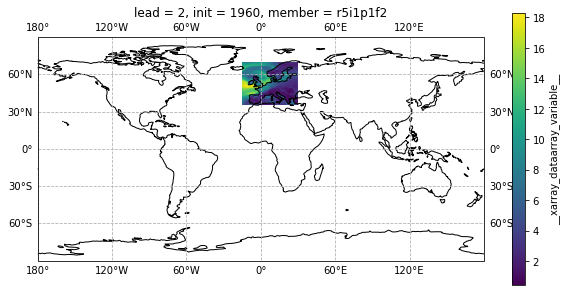

In [7]:
# plot the model data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
model_data["__xarray_dataarray_variable__"].isel(member=1, lead=1).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [8]:
print(udicts.eu_grid_constrained)

{'lon1': -15, 'lon2': 30, 'lat1': 35, 'lat2': 70}


In [9]:
# # Apply the mask for the european domain
# model_data = select_gridbox(
#     ds=model_data,
#     grid=udicts.eu_grid_constrained,
#     calc_mean=False,
# )

In [10]:
model_data

<xarray.Dataset>
Dimensions:                        (lead: 30, init: 1, member: 10, lat: 324,
                                    lon: 432)
Coordinates:
  * lead                           (lead) int64 1 2 3 4 5 6 ... 26 27 28 29 30
  * init                           (init) int64 1960
  * member                         (member) object 'r10i1p1f2' ... 'r9i1p1f2'
  * lat                            (lat) float64 -89.72 -89.17 ... 89.17 89.72
  * lon                            (lon) float64 -179.6 -178.8 ... 178.7 179.6
Data variables:
    __xarray_dataarray_variable__  (init, member, lead, lat, lon) float64 ...

In [11]:
# load the observed data
obs_data = xr.open_dataset(os.path.join(ERA5_dir, fname_test))

In [12]:
obs_data

<xarray.Dataset>
Dimensions:    (time: 2192, longitude: 304, latitude: 214)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-01-02 ... 1965-12-31
  * longitude  (longitude) float32 -45.0 -44.72 -44.44 ... 39.66 39.94 40.22
  * latitude   (latitude) float32 89.78 89.51 89.23 88.95 ... 30.49 30.21 29.93
Data variables:
    si10       (time, latitude, longitude) float32 ...
    si100_bc   (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jul 15 10:27:16 2024: cdo selyear,1960,1961,1962,1963,1...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

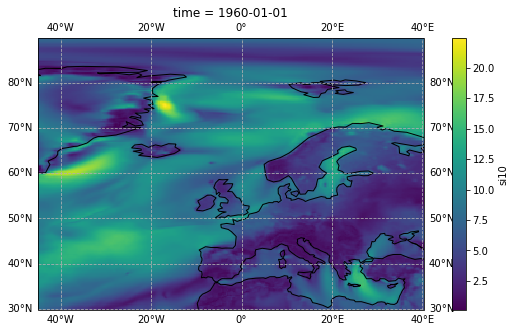

In [13]:
# plot the obs data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
obs_data["si10"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [14]:
print(udicts.eu_grid_constrained)

{'lon1': -15, 'lon2': 30, 'lat1': 35, 'lat2': 70}


In [15]:
# # set up a constant grid
# grid = {
#     "lon1": -40,
#     "lon2": 40,
#     "lat1": 30,
#     "lat2": 80,
# }

In [16]:
obs_data

<xarray.Dataset>
Dimensions:    (time: 2192, longitude: 304, latitude: 214)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-01-02 ... 1965-12-31
  * longitude  (longitude) float32 -45.0 -44.72 -44.44 ... 39.66 39.94 40.22
  * latitude   (latitude) float32 89.78 89.51 89.23 88.95 ... 30.49 30.21 29.93
Data variables:
    si10       (time, latitude, longitude) float32 ...
    si100_bc   (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jul 15 10:27:16 2024: cdo selyear,1960,1961,1962,1963,1...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [17]:
# subset the observed data to the correct udicts.eu_grid_constrained
obs_data = obs_data.sel(
    longitude=slice(udicts.eu_grid_constrained["lon1"], udicts.eu_grid_constrained["lon2"]),
    latitude=slice(udicts.eu_grid_constrained["lat2"], udicts.eu_grid_constrained["lat1"]),
)

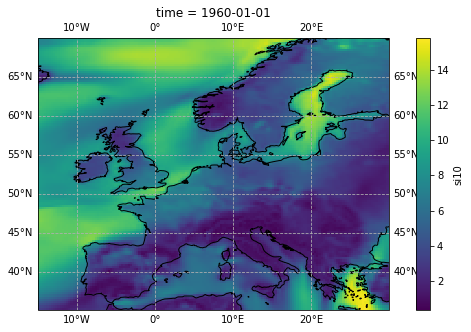

In [18]:
# plot the obs data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
obs_data["si10"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [19]:
# subset the model data to the same udicts.eu_grid_constrained
model_data = model_data.sel(
    lon=slice(udicts.eu_grid_constrained["lon1"], udicts.eu_grid_constrained["lon2"]),
    lat=slice(udicts.eu_grid_constrained["lat1"], udicts.eu_grid_constrained["lat2"]),
)

In [20]:
model_data

<xarray.Dataset>
Dimensions:                        (lead: 30, init: 1, member: 10, lat: 63,
                                    lon: 54)
Coordinates:
  * lead                           (lead) int64 1 2 3 4 5 6 ... 26 27 28 29 30
  * init                           (init) int64 1960
  * member                         (member) object 'r10i1p1f2' ... 'r9i1p1f2'
  * lat                            (lat) float64 35.28 35.83 ... 69.17 69.72
  * lon                            (lon) float64 -14.58 -13.75 ... 28.75 29.58
Data variables:
    __xarray_dataarray_variable__  (init, member, lead, lat, lon) float64 ...

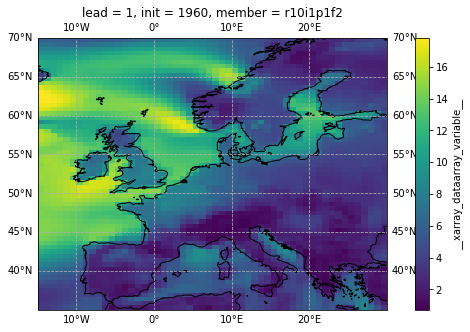

In [21]:
# plot the model data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
model_data["__xarray_dataarray_variable__"].isel(member=0, lead=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [45]:
# convert model data to iris cubes
selected_member = model_data['__xarray_dataarray_variable__'].sel(member='r10i1p1f2')

In [50]:
# rename the variable
selected_member = selected_member.rename('sfcWind')

In [55]:
# convert to iris cube
member_cube = selected_member.squeeze().to_iris()

In [56]:
member_cube

<iris 'Cube' of sfcWind / (unknown) (lead: 30; lat: 63; lon: 54)>

In [69]:
# rename lat and lon
member_cube.coord('lat').rename('latitude')
member_cube.coord('lon').rename('longitude')

In [70]:
# # use iris to regrid the obs data to the same grid asthe model data
# # convert obs data to a cube from xarray
obs_cube = cubes_from_xarray(obs_data)

In [73]:
# make cure the units match
member_cube.coord("latitude").units = obs_cube[0].coord("latitude").units
member_cube.coord("longitude").units = obs_cube[0].coord("longitude").units

# and for the attributes
member_cube.coord("latitude").attributes = obs_cube[0].coord("latitude").attributes
member_cube.coord("longitude").attributes = obs_cube[0].coord("longitude").attributes

In [74]:
# regrid the si10 obs cube
obs_cube_regrid = obs_cube[0].regrid(member_cube, iris.analysis.Linear())

In [76]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

In [79]:
# select first time of iris cube
obs_cube_regrid = obs_cube_regrid[0]

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2058: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2058: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


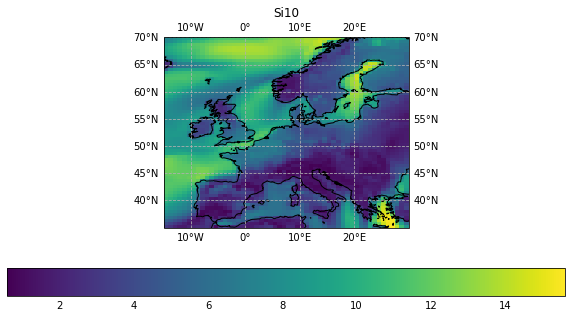

In [84]:
# plot the regridded obs data
fig = plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
qplt.pcolormesh(obs_cube_regrid, cmap='viridis')
plt.show()

In [23]:
# # set up the single file
# single_file = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

# # load the single file using iris
# model_ex_cube = iris.load_cube(single_file)

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(


In [88]:
model_data["__xarray_dataarray_variable__"]

<xarray.DataArray '__xarray_dataarray_variable__' (init: 1, member: 10,
                                                   lead: 30, lat: 63, lon: 54)>
[1020600 values with dtype=float64]
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * init     (init) int64 1960
  * member   (member) object 'r10i1p1f2' 'r5i1p1f2' ... 'r3i1p1f2' 'r9i1p1f2'
  * lat      (lat) float64 35.28 35.83 36.39 36.94 ... 68.06 68.61 69.17 69.72
  * lon      (lon) float64 -14.58 -13.75 -12.92 -12.08 ... 27.92 28.75 29.58

In [91]:
import re

In [100]:
model_data['member'] = model_data['member'].str[1:-6].astype(int)


In [104]:
model_data_var = model_data['__xarray_dataarray_variable__']

In [105]:
# rename the variable as sfcWind
model_data_var = model_data_var.rename('sfcWind')

In [106]:
# convert to iris cube
model_cube = model_data_var.squeeze().to_iris()

In [108]:
model_cube.shape

(10, 30, 63, 54)

Then loop over the model cube, for each init, member, lead, find the obs day (date) with the smallest absolute difference for the si10 field (for regridded obs). Come up with a list of dates to be extracted from the observations and then see whether this produces a semi-realistic time series.